# Interprocedural Analysis

## Control flow

We first start by re-defining the already established aspects of our control flow graph. Since our aim is to combine multiple methods, we update our node labels to include the method name, and not just the line number.

In [1]:
import javalang

In [2]:
class CFGNode:
    def __init__(self, graph, method_name, ast_node):
        self.graph = graph
        self.method_name = method_name
        self.ast_node = ast_node
        
    def __str__(self):
        if type(self.ast_node) == str:
            return self.method_name + "_" + self.ast_node
        else:
            return self.method_name + "_" + str(self.ast_node.position.line - 1)

In [3]:
class StartNode:
    
    def __init__(self, graph, method_name, ast_node):
        self.graph = graph
        self.method_name = method_name
        self.ast_node = ast_node
    
    def __str__(self):
        return self.method_name + "_Start"

In [4]:
class ProgramGraph:
    def __init__(self, graph, start, end):
        self.graph = graph
        self.start = start
        self.end   = end
        
    def nodes(self):
        return self.graph.nodes()
    
    def edges(self):
        return self.graph.edges()
    
    def successors(self, node):
        return self.graph.successors(node)
    
    def predecessors(self, node):
        return self.graph.predecessors(node)
    
    def reverse(self):
        reverse_cfg = self.graph.reverse()
        return ProgramGraph(reverse_cfg, self.end, self.start)    
    
    def plot(self):
        pos = nx.nx_agraph.graphviz_layout(self.graph, prog="dot")
        nx.draw_networkx_nodes(self.graph, pos=pos, node_size=800, node_color='#FFFFFF', edgecolors='#000000')
        nx.draw_networkx_edges(self.graph, pos=pos, connectionstyle="arc", arrowsize=20)
        nx.draw_networkx_labels(self.graph, pos=pos)
        nx.draw_networkx_edge_labels(self.graph, pos=pos, edge_labels=nx.get_edge_attributes(self.graph,'label'))

In [5]:
import networkx as nx

In [6]:
from functools import singledispatchmethod

In [7]:
class CFGBuilder:
    def __init__(self, method_declaration):
        # create graph
        self.graph = nx.DiGraph()
        self.method_name = method_declaration.name
        
        # create entry/end node
        self.start = StartNode(self.graph, self.method_name, method_declaration)
        self.end   = CFGNode(self.graph, self.method_name, "End")
        self.graph.add_node(self.start)
        self.graph.add_node(self.end)
        
        # set entry as current target
        self.frontier = [ self.start ]
        
        for node in method_declaration.body:
            self.add_node(node)
            
        # Add edges from last nodes to end node
        for parent in self.frontier:
            self.graph.add_edge(parent, self.end)

    def create_graph(self):
        return ProgramGraph(self.graph, self.start, self.end)
    
    @singledispatchmethod
    def add_node(self, node):
        pass
    
    @add_node.register        
    def add_block_node(self, block_node: javalang.tree.BlockStatement):
        for node in block_node.statements:
            self.add_node(node)            
    
    @add_node.register
    def add_statement_node(self, node: javalang.tree.StatementExpression):
        cfg_node = CFGNode(self.graph, self.method_name, node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [ cfg_node ]
        
    @add_node.register
    def add_declaration_node(self, node: javalang.tree.LocalVariableDeclaration):
        self.add_statement_node(node)
        
    @add_node.register
    def add_if_node(self, if_node: javalang.tree.IfStatement):
        cfg_node = CFGNode(self.graph, self.method_name, if_node)
        self.graph.add_node(cfg_node)

        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [cfg_node]
        self.add_node(if_node.then_statement)
        
        if if_node.else_statement:
            current_frontier = self.frontier[:]
            self.frontier = [cfg_node]
            self.add_node(if_node.else_statement)
            self.frontier.extend(current_frontier)
        else:
            self.frontier.append(cfg_node)
            
    @add_node.register
    def add_while_node(self, while_node: javalang.tree.WhileStatement):
        cfg_node = CFGNode(self.graph, self.method_name, while_node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [cfg_node]
        self.add_node(while_node.body)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [cfg_node]

    @add_node.register
    def add_return_node(self, return_node: javalang.tree.ReturnStatement):
        cfg_node = CFGNode(self.graph, self.method_name, return_node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.graph.add_edge(cfg_node, self.end)
        self.frontier = [] 

This time we want to keep track of multiple methods, so we keep track of the known methods with a dictionary `methods`.

In [8]:
methods = {}

In [9]:
def parse_method(code):
    class_code = "class Dummy {\n" + code + "\n}";
    tokens = javalang.tokenizer.tokenize(class_code)
    parser = javalang.parser.Parser(tokens)
    ast = parser.parse()
    _, node = list(ast.filter(javalang.tree.MethodDeclaration))[0]
    methods[node.name] = node
    return node

In [10]:
code1 = """
  public int foo(int x) {
    int y = 0;

    while (!bar(y)) {
        int tmp = x;
        if(tmp % 2 == 0)
            y = x;
        x--;
    }

    return y;
  }
"""

In [11]:
code2 = """
  public boolean bar(int x) {
    if (x == 42) {
      return true;
    } else {
      return false;
    }
  }
"""

In [12]:
tree1 = parse_method(code1)

In [13]:
tree2 = parse_method(code2)

In [14]:
cfg1 = CFGBuilder(methods["foo"]).create_graph()
cfg2 = CFGBuilder(methods["bar"]).create_graph()

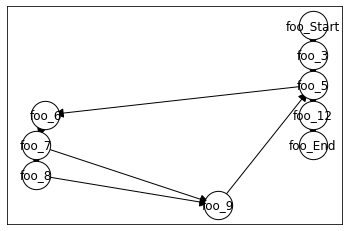

In [15]:
cfg1.plot()

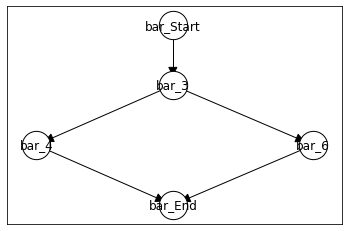

In [16]:
cfg2.plot()

## Super-CFG

Now that we have multiple methods, we can combine them in a super-control flow graph. For this, we need to determine for a given node whether it calls another function.

In [17]:
def get_children(root):
    children = None

    if isinstance(root, javalang.tree.Node):
        yield root
        children = root.children
    else:
        children = root

    for child in children:
        if isinstance(child, javalang.tree.Statement):
            continue
    
        if isinstance(child, (javalang.tree.Node, list, tuple)):
            for node in get_children(child):
                yield node

In [18]:
class CFGNode(CFGNode):
    def calls(self):
        calls = set()
        if not self.ast_node or isinstance(self.ast_node, str):
            return calls
        
        for node in get_children(self.ast_node):
            if isinstance(node, javalang.tree.MethodInvocation):
                calls.add(node)
                
        return calls

In [19]:
class StartNode(StartNode):
    def calls(self):
        return set()

In [20]:
cfg1 = CFGBuilder(tree1).create_graph()
cfg2 = CFGBuilder(tree2).create_graph()

In [21]:
for node in cfg1.nodes():
    for call in node.calls():
        print(f"Node {node} calls {call.member}")

Node foo_5 calls bar


Now let's define a function that expands a given control flow graph with all the control flow implied by method calls.

In [22]:
def build_super_cfg(cfg):
    
    graph = nx.DiGraph()
    
    # Copy over original nodes
    graph.add_nodes_from(cfg.graph.nodes())
    graph.add_edges_from(cfg.graph.edges())        

    # Find all method calls
    for node in cfg.nodes():
        for call in node.calls():
            # Retrieve cfg of called method
            cfg2 = CFGBuilder(methods[call.member]).create_graph()

            # Add all nodes and edges of called method
            graph.add_nodes_from(cfg2.graph.nodes())
            graph.add_edges_from(cfg2.graph.edges())

            # Connect calling node with start/end of new CFG
            graph.add_edge(node, cfg2.start)
            graph.add_edge(cfg2.end, node)

    return ProgramGraph(graph, cfg.start, cfg.end)

In [23]:
scfg = build_super_cfg(cfg1)

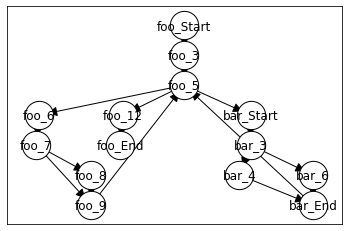

In [24]:
scfg.plot()

There is an issue with this direct integration: It creates possible loops in the method calls, which are not actually feasible. We therefore have to split method calls into call and return site.

In [25]:
class CallNode(CFGNode):
    def __init__(self, graph, method_name, ast_node, called_cfg):
        self.graph = graph
        self.method_name = method_name
        self.ast_node    = ast_node
        self.called_cfg  = called_cfg
    
    def __str__(self):
        return self.method_name + "_" + str(self.ast_node.position.line - 1) + " (Call)"

In [26]:
class ReturnNode(CFGNode):
    
    def __init__(self, graph, method_name, ast_node, return_node):
        self.graph = graph
        self.method_name = method_name
        self.ast_node = ast_node
        self.return_node = return_node

    def __str__(self):
        return self.method_name + "_" + str(self.ast_node.position.line - 1) + " (Return)"

In [27]:
def build_super_cfg(cfg):
    graph = nx.DiGraph()
    graph.add_edges_from(cfg.graph.edges())
    graph.add_nodes_from(cfg.graph.nodes())

    for node in cfg.nodes():
        if node.calls():
            for call in node.calls():
                # Retrieve cfg2
                cfg2 = CFGBuilder(methods[call.member]).create_graph()

                # Add all nodes and edges
                graph.add_nodes_from(cfg2.graph.nodes())
                graph.add_edges_from(cfg2.graph.edges())

                call_node   = CallNode(graph, node.method_name, node.ast_node, cfg2.start)
                return_node = ReturnNode(graph, node.method_name, node.ast_node, cfg2.end)
                for p in graph.predecessors(node):                    
                    graph.add_edge(p, call_node)
                for p in graph.successors(node):                    
                    graph.add_edge(return_node, p)
                graph.remove_node(node)
                
                graph.add_edge(call_node, cfg2.start)
                graph.add_edge(cfg2.end, return_node)

    return ProgramGraph(graph, cfg.start, cfg.end)

In [28]:
cfg1 = CFGBuilder(tree1).create_graph()
cfg2 = CFGBuilder(tree2).create_graph()

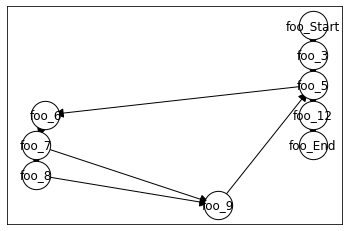

In [29]:
cfg1.plot()

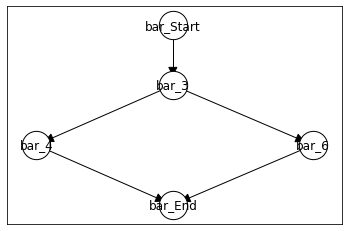

In [30]:
cfg2.plot()

In [31]:
scfg = build_super_cfg(cfg1)

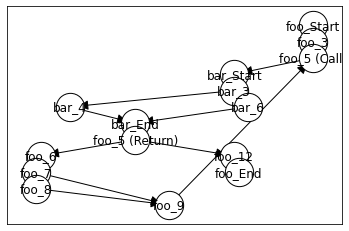

In [32]:
scfg.plot()

## Better Plotting

This is a terrible plot. Unfortunately, networkx isn't great for creating a cleaner version, so let's define a version using GraphViz directly.

In [33]:
from graphviz import Digraph

In [34]:
class ProgramGraph(ProgramGraph):
    def dot(self):
        graph = Digraph(graph_attr = {"rankdir" :  "TB" })
        
        methods = set([ node.method_name for node in self.nodes() ] )
        clusters = {}
        for method in methods:
            clusters[method] = Digraph(name = f"cluster_{method}")
        
        clusters[self.start.method_name].node(str(self.start))
        clusters[self.start.method_name].node(str(self.end))
        
        for node in self.nodes():
            clusters[node.method_name].node(str(node))
        
        for subgraph in clusters.values():
            graph.subgraph(subgraph)
            
        for (node1, node2) in self.edges():
            graph.edge(str(node1), str(node2))
        
        return graph

In [35]:
scfg = build_super_cfg(cfg1)

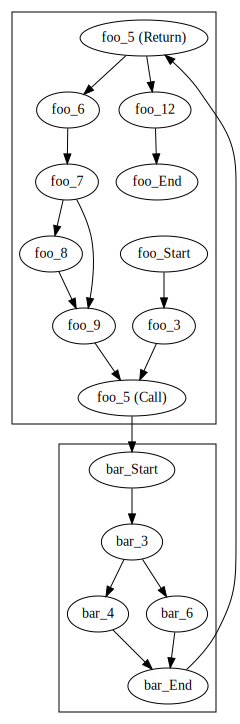

In [36]:
scfg.dot()

## Dataflow Analysis

Let's assume our objective is to apply our zero-analysis to the following code.

In [37]:
code1 = """
  public int foo() {

    int x = 5;
    int y = bar(x);
    int z = x/y;

    return z;
  }
"""

In [38]:
code2 = """
  public int bar(int a) {
    return a;
  }
"""

In [39]:
tree1 = parse_method(code1)
tree2 = parse_method(code2)

In [40]:
cfg1 = CFGBuilder(tree1).create_graph()
cfg2 = CFGBuilder(tree2).create_graph()

In [41]:
scfg = build_super_cfg(cfg1)

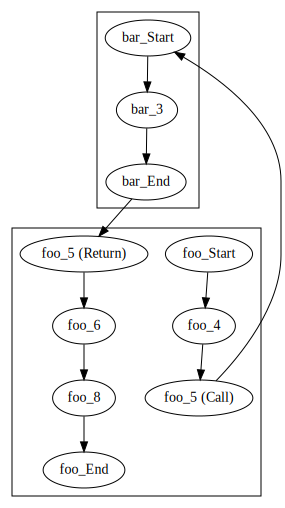

In [42]:
scfg.dot()

### Analysis code

We'll need to re-introduce all the analysis code.

In [43]:
class ProgramLattice(object):
    def __init__(self, variables, lattice):
        self.variables = variables
        self.lattice   = lattice
        self.values    = {}
        for var in variables:
            self.values[var] = lattice.bottom

    @property
    def bottom(self):
        new_lattice = ProgramLattice(self.variables, self.lattice)
        for var in self.variables:
            new_lattice.values[var] = self.lattice.bottom
        return new_lattice
    
    def join(self, other):
        new_lattice = ProgramLattice(self.variables, self.lattice)
        for var in self.variables:
            new_lattice.values[var] = self.lattice.join(self.values[var], other.values[var])
        return new_lattice
    
    def copy(self):
        new_lattice = ProgramLattice(self.variables, self.lattice)
        new_lattice.values = self.values.copy()
        return new_lattice 
    
    def __le__(self, other):
        for var in self.variables:
            if not (self.values[var] <= other.values[var]):
                return False

        return True

    def __str__(self):
        result = ""
        for var, value in self.values.items():
            result += f"{var}: {value}\n"
        return result

In [44]:
class DataFlowAnalysis:
    def __init__(self, cfg, program_lattice, transfer_function, is_backward):
        self.cfg = cfg
        if is_backward:
            self.cfg = cfg.reverse()
            
        self.transfer_function = transfer_function
        self.lattice = program_lattice
        
        self.facts = {}
        
        for node in cfg.nodes():
            self.facts[node] = program_lattice.bottom    

In [45]:
class DataFlowAnalysis(DataFlowAnalysis):
    def apply(self):
            
        worklist = [(edge[0], edge[1]) for edge in self.cfg.edges()]
        while worklist:
            node1, node2 = worklist.pop()
            result = self.transfer_function(node1, node2, self.facts[node1])
            self.facts[node1] = result
            if not (result <= self.facts[node2]):
                self.facts[node2] = self.facts[node2].join(result)
                for successor in self.cfg.successors(node2):
                    worklist.append((node2, successor))

In [46]:
def variables(cfg):
    # Assumes parameters are used
    variables = set()
    for node in cfg.nodes():
        for child in get_children(node.ast_node):
            if isinstance(child, javalang.tree.MemberReference):
                variables.add(child.member)
    
    return variables

In [47]:
variables(scfg)

{'a', 'x', 'y', 'z'}

### Zero-Abstraction

In [48]:
from enum import Enum
class IntegerValue(Enum):
    ZERO = 1
    NONZERO = 2
    
    def __repr__(self):
        return self.name

In [49]:
class Lattice(object):
    def __init__(self, elements, join_func, meet_func):
        self.elements = elements
        self.join = join_func
        self.meet = meet_func

    def wrap(self, object):
        return LatticeElement(self, object)

    def element_by_index(self, index):
        return LatticeElement(self, self.elements[index])

    @property
    def top(self):
        top = self.wrap(self.elements[0])
        for element in self.elements[1:]:
            top |= self.wrap(element)
        return top

    @property
    def bottom(self):
        bottom = self.wrap(self.elements[0])
        for element in self.elements[1:]:
            bottom &= self.wrap(element)
        return bottom

In [50]:
class LatticeElement():
    def __init__(self, lattice, element):
        if element not in lattice.elements: raise ValueError('The given value is not a lattice element')
        self.lattice = lattice
        self.index = lattice.elements.index(element)

    @property
    def unwrap(self):
        return self.lattice.elements[self.index]

    def __and__(self, b):
        # a.__and__(b) <=> a & b <=> meet(a,b)
        return LatticeElement(self.lattice, self.lattice.meet(self.unwrap, b.unwrap))

    def __or__(self, b):
        # a.__or__(b) <=> a | b <=> join(a,b)
        return LatticeElement(self.lattice, self.lattice.join(self.unwrap, b.unwrap))

    def __eq__(self, b):
        # a.__eq__(b) <=> a = b <=> join(a,b)
        return self.unwrap == b.unwrap

    def __le__(self, b):
        # a <= b if and only if a = a & b,
        # or
        # a <= b if and only if b = a | b,
        a = self
        return ( a == a & b ) or ( b == a | b )

    def __str__(self):
        return str(self.unwrap)

In [51]:
powerset = [set(), {IntegerValue.ZERO}, {IntegerValue.NONZERO}, {IntegerValue.ZERO, IntegerValue.NONZERO}]

In [52]:
def intersection(a, b):
    return a & b 

def union(a, b):
    return a | b 

In [53]:
join = union
meet = intersection

zero_lattice = Lattice(powerset, join, meet)

In [54]:
zero = zero_lattice.wrap({ IntegerValue.ZERO })
nonzero =  zero_lattice.wrap({ IntegerValue.NONZERO })
maybezero = zero_lattice.wrap({ IntegerValue.ZERO, IntegerValue.NONZERO })

In [55]:
from functools import singledispatch

In [56]:
@singledispatch
def alpha(arg):
    raise NotImplementedError(f"Cannot abstract {arg}") 

In [57]:
@alpha.register(int)
def alpha_number(number):
    if number == 0:
        return zero
    else:
        return nonzero

In [58]:
def abstract_addition(op1, op2):
    if op1 == zero_lattice.bottom or op2 == zero_lattice.bottom:
        return zero_lattice.bottom
    elif op1 == zero:
        if  op2 == zero:
            return zero
        elif op2 == nonzero:
            return nonzero
    elif op2 == zero and op1 == nonzero:
            return nonzero
    else:
        return maybezero

In [59]:
abstract_subtraction = abstract_addition

In [60]:
def abstract_multiplication(op1, op2):
    if op1 == zero or op2 == zero:
        return zero
    elif op1 == nonzero and op2 == nonzero:
        return nonzero
    elif op1 == maybezero and op2 == maybezero:
            return maybezero
    else:
        return zero_lattice.bottom

In [61]:
def abstract_division(op1, op2):
    if op2 == zero:
        return zero_lattice.bottom
    elif op1 == zero_lattice.bottom:
        return zero_lattice.bottom
    elif op1 == zero:
        return zero
    elif op1 == nonzero and op2 == nonzero:
        return nonzero
    elif op1 == nonzero and op2 == maybezero:
        return nonzero
    elif op1 == zero_lattice.bottom:
        return zero_lattice.bottom
    else:
        return maybezero

### Abstract interpretation

As a first change to the last chapter, we need to add code to handle method calls. Let's re-introduce our transfer function for the zero analysis. This is identical code to last time, but in preparation for the coming changes we include the CFG node a statement originates from (though we don't make use of this for now).

In [62]:
@singledispatch
def alpha(arg, cfg_node, values):
    raise NotImplementedError(f"Cannot abstract {arg}") 

In [63]:
@alpha.register(int)
def alpha_number(number, cfg_node, values = {}):
    if number == 0:
        return zero
    else:
        return nonzero

In [64]:
@alpha.register(javalang.tree.Literal)
def alpha_literal(lit, cfg_node, values):
    return alpha(lit.value, cfg_node, values)

In [65]:
@alpha.register(javalang.tree.MemberReference)
def alpha_member(member, cfg_node, values):
    if member.member in values:
        return values[member.member]
    else:
        return zero_lattice.bottom

In [66]:
@alpha.register(str)
def alpha_string(string, context, values):
    return alpha_number((int(string)), context, values)

In [67]:
@alpha.register(javalang.tree.Assignment)
def alpha_assignment(assignment, cfg_node, values):
    if not isinstance(assignment.expressionl, javalang.tree.MemberReference):
        raise NotImplementError(f"Assignment not implemented for {assignment.expressionl}")

    var = assignment.expressionl.member
    values[var] = alpha(assignment.value, cfg_node, values)    

In [68]:
@alpha.register(javalang.tree.BinaryOperation)
def alpha_operation(operation, cfg_node, values):
    lhs = alpha(operation.operandl, cfg_node, values)
    rhs = alpha(operation.operandr, cfg_node, values)
    op  = operation.operator
    if op == "+":
        return abstract_addition(lhs, rhs)
    elif op == "-":
        return abstract_subtraction(lhs, rhs)
    elif op == "*":
        return abstract_multiplication(lhs, rhs)
    elif op == "/":
        return abstract_division(lhs, rhs)
    else:
        raise NotImplementedError(f"Operator not implemented: {op}") 

In [69]:
@alpha.register(javalang.tree.LocalVariableDeclaration)
def alpha_declaration(declaration, cfg_node, values):
    var = declaration.declarators[0].name
    value = alpha(declaration.declarators[0].initializer, cfg_node, values)
    values[var] = value

In [70]:
@alpha.register(javalang.tree.StatementExpression)
def alpha_statement(statement, cfg_node, values):
    alpha(statement.expression, cfg_node, values)

In [71]:
@alpha.register(javalang.tree.WhileStatement)
def alpha_while(whilestatement, cfg_node, values):
    pass

In [72]:
@alpha.register(javalang.tree.ReturnStatement)
def alpha_return(statement, cfg_node, values):
    pass

In [73]:
@alpha.register(javalang.tree.IfStatement)
def alpha_if(statement, cfg_node, values):
    pass

In [74]:
@alpha.register(javalang.tree.MethodDeclaration)
def alpha_method(statement, cfg_node, values):
    pass

Last time we did not support method calls. For starters, we can just assume that anything can happen with a method call.

In [75]:
@alpha.register(javalang.tree.MethodInvocation)
def alpha_methodcall(statement, cfg_node, values):
    
    # Conservative: Can be anything
    return maybezero

In [76]:
def alpha_trans(node, node2, in_facts):
    result = in_facts.copy()
    alpha(node.ast_node, node, result.values)

    return result

First, let's apply the analysis directly to the method `foo`.

In [77]:
P = ProgramLattice(variables(cfg1), zero_lattice)

In [78]:
analysis = DataFlowAnalysis(cfg1, P, alpha_trans, False)

In [79]:
analysis.apply()

In [80]:
for node, facts in analysis.facts.items():
    print(f"{node}: {facts}")

foo_Start: y: set()
x: set()
z: set()

foo_End: y: {NONZERO, ZERO}
x: {NONZERO}
z: {NONZERO}

foo_4: y: set()
x: {NONZERO}
z: set()

foo_5: y: {NONZERO, ZERO}
x: {NONZERO}
z: set()

foo_6: y: {NONZERO, ZERO}
x: {NONZERO}
z: {NONZERO}

foo_8: y: {NONZERO, ZERO}
x: {NONZERO}
z: {NONZERO}



In [81]:
for i, line in enumerate(code1.split('\n')):
    print(str(i + 1).rjust(3, ' '), ':', line)

  1 : 
  2 :   public int foo() {
  3 : 
  4 :     int x = 5;
  5 :     int y = bar(x);
  6 :     int z = x/y;
  7 : 
  8 :     return z;
  9 :   }
 10 : 


In [82]:
def check_divisionbyzero(cfg):
    for node in cfg.nodes():
        for ast_node in get_children(node.ast_node):
            if isinstance(ast_node, javalang.tree.BinaryOperation):
                if ast_node.operator == "/" and isinstance(ast_node.operandr, javalang.tree.MemberReference):
                    if zero == analysis.facts[node].values[ast_node.operandr.member]:
                        print(f"Division by zero in line {node.ast_node.position.line - 1}")
                    elif zero <= analysis.facts[node].values[ast_node.operandr.member]:
                        print(f"Potential division by zero in line {node.ast_node.position.line - 1}")

In [83]:
check_divisionbyzero(cfg1)

Potential division by zero in line 6


This analysis assumes that there can be a division by zero exception in our division, since we did not consider what the call to `bar` actually returns and just assumed it can be anything. However, we know this cannot be the case since we pass in a non-zero argument to `bar`, and it just returns its input again.

### Interprocedural analysis

To generalise this to an interprocedural analysis, we need to relax our assumption that methods return anything, and instead descend into the super-cfg during our analysis.

We need some way to pass values through method parameters and return values. For now, we'll just use a dedicated variable to represent the return value of the function; therefore, we need to make sure this is included in our set of variables.

In [84]:
def variables(cfg):
    variables = set()
    methods = set()
    
    for node in cfg.nodes():
        methods.add(node.method_name)
        for child in get_children(node.ast_node):
            if isinstance(child, javalang.tree.MemberReference):
                variables.add(child.member)

    for method in methods:
        variables.add("return_"+method)
    
    return variables

This variable is set in return statements.

In [85]:
@alpha.register(javalang.tree.ReturnStatement)
def alpha_return(statement, cfg_node, values):
    values["return_"+cfg_node.method_name] = alpha(statement.expression, cfg_node, values)
    return values["return_"+cfg_node.method_name]

Method calls are used in variable declarations and assignments, we if we encounter a method call we let our abstraction return the return value stored for this call.

In [86]:
@alpha.register(javalang.tree.MethodInvocation)
def alpha_methodcall(statement, cfg_node, values):

    ctx = f"return_{statement.member}"
    if ctx in values:
        return values[ctx]
    else:
        return zero_lattice.bottom

Our transfer function needs to handle passing the parameters into functions in the call nodes. We just assign the values used to the variables that represent the arguments in the called method.

In [87]:
def alpha_trans(node, target_node, in_facts):
    result = in_facts.copy()
    
    if isinstance(node, CallNode):
        for _, call in node.ast_node.filter(javalang.tree.MethodInvocation):
            called_method = methods[call.member]
            num_argument = 0
            for argument in call.arguments:
                var = called_method.parameters[num_argument].name
                result.values[var] |= alpha(argument, target_node, result.values)
                num_argument += 1
    elif node.ast_node == "End":
        pass
    else:    
        alpha(node.ast_node, node, result.values)

    return result

The analysis now has to be applied to the super-CFG:

In [88]:
P = ProgramLattice(variables(scfg), zero_lattice)

In [89]:
analysis = DataFlowAnalysis(scfg, P, alpha_trans, False)

In [90]:
analysis.apply()

In [91]:
check_divisionbyzero(scfg)

No false positive is reported!

What if there is an actual division by zero?

In [92]:
code1 = """
  public int foo() {

    int x = 0;
    int y = bar(x);
    int z = x/y;

    return z;
  }
"""

In [93]:
tree1 = parse_method(code1)
tree2 = parse_method(code2)

In [94]:
cfg1 = CFGBuilder(tree1).create_graph()
cfg2 = CFGBuilder(tree2).create_graph()

In [95]:
scfg = build_super_cfg(cfg1)

In [96]:
analysis = DataFlowAnalysis(scfg, P, alpha_trans, False)

In [97]:
analysis.apply()

In [98]:
check_divisionbyzero(scfg)

Division by zero in line 6


## Imprecision of interprocedural analysis

Let's now consider a case where we call the same function twice.

In [99]:
code1 = """
  public int foo() {

    int x = bar(0);
    int y = bar(5);
    
    z = 5/x;
    z = 5/y;

    return z;
  }
"""

In [100]:
code2 = """
  public int bar(int a) {
    return a;
  }
"""

In [101]:
tree1 = parse_method(code1)
tree2 = parse_method(code2)

cfg1 = CFGBuilder(tree1).create_graph()
cfg2 = CFGBuilder(tree2).create_graph()

scfg = scfg = build_super_cfg(cfg1)

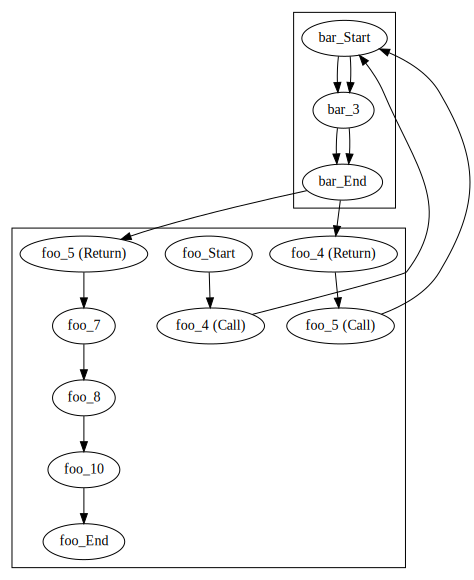

In [102]:
scfg.dot()

Line 7 does not contain a division by zero exception, while line 8 does. What does our analysis say?

In [103]:
P = ProgramLattice(variables(scfg), zero_lattice)

In [104]:
analysis = DataFlowAnalysis(scfg, P, alpha_trans, False)

In [105]:
analysis.apply()

In [106]:
check_divisionbyzero(scfg)

Division by zero in line 7
Potential division by zero in line 8


There indeed is a division by zero in line 7, but line 8 is a false positive.

## Cloning

There are multiple different strategies to create context-sensitive analyses. One easy approach is to simply clone the called methods.

In [107]:
def build_super_cfg_clones(cfg):
    graph = nx.DiGraph()
    graph.add_edges_from(cfg.graph.edges())    
    graph.add_nodes_from(cfg.graph.nodes())    
    clones = {}  # To count how many clones there are of each method 

    for node in cfg.nodes():
        calls = node.calls()
        if node.calls():
            for call in node.calls():
                # Retrieve cfg2
                cfg2 = CFGBuilder(methods[call.member]).create_graph()

                num = 1
                if call.member in clones:
                    num = clones[call.member] + 1
                clones[call.member]  = num

                # Add all nodes and edges
                for nod in cfg2.graph.nodes():
                    nod.method_name += f"_{num}"
                    nod.graph = graph
                    graph.add_node(nod)
                graph.add_edges_from(cfg2.graph.edges())

                call_node = CallNode(graph, node.method_name, node.ast_node, cfg2.start)
                return_node = ReturnNode(graph, node.method_name, node.ast_node, cfg2.end)
                for p in graph.predecessors(node):                    
                    graph.add_edge(p, call_node)
                for p in graph.successors(node):
                    graph.add_edge(return_node, p)
                graph.remove_node(node)

                graph.add_edge(call_node, cfg2.start)
                graph.add_edge(cfg2.end, return_node)

    return ProgramGraph(graph, cfg.start, cfg.end)


In [108]:
scfg_clones = build_super_cfg_clones(cfg1)

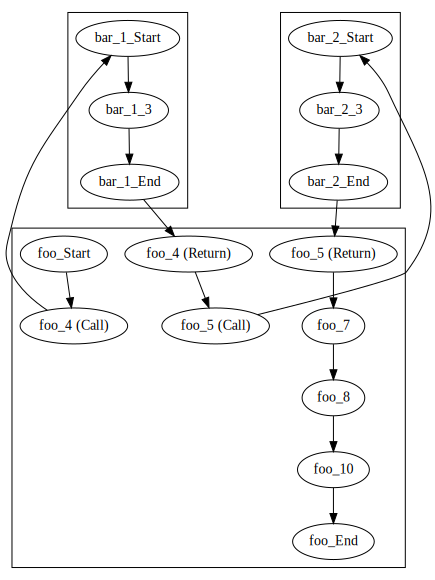

In [109]:
scfg_clones.dot()

In [110]:
@alpha.register(javalang.tree.MethodInvocation)
def alpha_methodcall(statement, cfg_node, values):

    for s in cfg_node.graph.predecessors(cfg_node):
        if str(s).endswith("End"):
            ctx = f"return_{s.method_name}"
            if ctx in values:
                return values[ctx]
    return zero_lattice.bottom

In [111]:
def alpha_trans(node, target_node, in_facts):
    result = in_facts.copy()
    
    if isinstance(node, CallNode):   
        for _, call in node.ast_node.filter(javalang.tree.MethodInvocation):
            called_method = methods[call.member]
            num_argument = 0
            for argument in call.arguments:
                var = called_method.parameters[num_argument].name
                # Assign rather than join
                result.values[var] = alpha(argument, target_node, result.values)
                num_argument += 1
    elif node.ast_node == "End":
        pass
    else:    
        alpha(node.ast_node, node, result.values)

    return result

In [112]:
variables(scfg_clones)

{'a', 'return_bar_1', 'return_bar_2', 'return_foo', 'x', 'y', 'z'}

In [113]:
P = ProgramLattice(variables(scfg_clones), zero_lattice)

In [114]:
analysis = DataFlowAnalysis(scfg_clones, P, alpha_trans, False)

In [115]:
analysis.apply()

In [116]:
check_divisionbyzero(scfg_clones)

Division by zero in line 7


Cloning is just one example of how to create a context-sensitive analysis, and as discussed in the lecture there are some limitations to think of (e.g. recursion). For the assignment, other alternatives (e.g. call strings) may be easier?